#### Readme
该NLP任务的主要目标为，通过纽约时报的新闻文本数据进行分析，预测未来可能发生的经济危机预警。

本任务的数据集为纽约时报1920-2020 的新闻标题和文本，以及1986-2012年美国发生的经济危机的时间戳（以年为单位）
输入为某些年份（本例是过去五年）每年的文本情感指标，输出为次年发生经济危机的概率和严重程度

此任务涉及的主要方法包括：
1. 文本情感指标提取方法：采用金融情感词典计算对一条新闻样本的情感指标，按照时间进行平均，得到月度和年度情感指标
2. 情感与金融危机相关性评估：采用逻辑回归；考虑到经济危机往往具有一定的周期性，我们考虑多年多月份的新闻情感指标作为输入

In [1]:
%%time
# python = 3.10
import pyarrow.parquet as pq # 14.0.1
import numpy as np # 1.26.2
import pandas as pd # 2.1.3
import re #
import nltk # 3.8.1

from nltk import pos_tag # 词性
from nltk.tokenize import word_tokenize # 分词
from nltk.corpus import stopwords # 停用词
from nltk.stem import PorterStemmer, WordNetLemmatizer # 词干化，词态统一
from tqdm import tqdm  # 显示处理进度
tqdm.pandas(desc="Processing excerpts")

CPU times: total: 2.02 s
Wall time: 7.32 s


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# run only once 第一次运行没下载要下载
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet') 
# nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) # 定义停用词

#### 1986-2012年的经济危机（US）

America(1986-2012) Romer&RomerCrisesAppendixA DerivationofNewMeasure.pdf

United States
- 1986:1 Credit disrupt.-minus
- 1990:1 Minor crisis-reg.
- 1990:2 Moderate crisis-minus
- 1991:1 Minor crisis-minus
- 1991:2 Credit disrupt.-plus
- 1992:1 Credit disrupt.-reg.
- 1998:2 Credit disrupt.-plus
- 2007:1 Credit disrupt.-minus
- 2007:2 Moderate crisis-minus
- 2008:1 Moderate crisis-plus
- 2008:2 Extreme crisis-reg.
- 2009:1 Major crisis-minus
- 2009:2 Moderate crisis-minus
- 2010:1 Minor crisis-plus
- 2010:2 Credit disrupt.-plus
- 2011:2 Credit disrupt.-reg.
- 2012:1 Credit disrupt.-minus
- 2012:2 Credit disrupt.-minus

In [133]:
# 假设我们有经济危机时间戳的数据列表
crisis_timestamps = [
    "1986:1 Credit disrupt.-minus",
    "1990:1 Minor crisis-reg.",
    "1990:2 Moderate crisis-minus",
    "1991:1 Minor crisis-minus",
    "1991:2 Credit disrupt.-plus",
    "1992:1 Credit disrupt.-reg.",
    "1998:2 Credit disrupt.-plus",
    "2007:1 Credit disrupt.-minus",
    "2007:2 Moderate crisis-minus",
    "2008:1 Moderate crisis-plus",
    "2008:2 Extreme crisis-reg.",
    "2009:1 Major crisis-minus",
    "2009:2 Moderate crisis-minus",
    "2010:1 Minor crisis-plus",
    "2010:2 Credit disrupt.-plus",
    "2011:2 Credit disrupt.-reg.",
    "2012:1 Credit disrupt.-minus",
    "2012:2 Credit disrupt.-minus"
]

# 定义危机的严重程度和修饰符的标量值
crisis_severity = {
    'Minor crisis': 4,
    'Moderate crisis': 7,
    'Major crisis': 10,
    'Extreme crisis': 13,
    'Credit disrupt.': 1  
}

# 对修饰符进行数值调整
modifier_adjustment = {
    'minus': 0.0,
    'plus': 2.0,
    'reg.': 1.0
}

# 创建一个空的DataFrame来存储结果
crisis_data = pd.DataFrame(columns=['Year', 'Severity', 'Binary_Crisis'])

# 处理每个时间戳，填充DataFrame
for timestamp in crisis_timestamps:
    # 解析年份和描述
    year, _, description = timestamp.partition(':')
    year = int(year)  # 转换年份为整数
    # 解析危机类型和修饰符
    for crisis_type in crisis_severity:
        if crisis_type in description:
            severity_value = crisis_severity[crisis_type]
            # 找到修饰符并进行调整
            for modifier in modifier_adjustment:
                if modifier in description:
                    severity_value += modifier_adjustment[modifier]
                    break  # 找到修饰符后无需继续查找
            # 添加到DataFrame
            crisis_data = crisis_data._append({
                'Year': year,
                'Severity': severity_value,
                'Binary_Crisis': 1  # 如果记录中有危机描述则标为1
            }, ignore_index=True)
            break  # 危机类型已找到，无需继续其它类型的检查

# 确保年份是整数类型
crisis_data['Year'] = crisis_data['Year'].astype(int)
crisis_data['Binary_Crisis'] = crisis_data['Binary_Crisis'].astype(int)
# 输出结果
crisis_data

,Year,Severity,Binary_Crisis
0,1986,1.0,1
1,1990,5.0,1
2,1990,7.0,1
3,1991,4.0,1
4,1991,3.0,1
5,1992,2.0,1
6,1998,3.0,1
7,2007,1.0,1
8,2007,7.0,1
9,2008,9.0,1


In [136]:
# 首先，对同一年份的危机严重性分数求和
# 对Binary_Crisis采取最大值，因为如果有危机，Binary_Crisis应该是1
aggregated_crisis_data = crisis_data.groupby('Year').agg({'Severity': 'max', 'Binary_Crisis': 'max'}).reset_index()

# 现在，aggregated_crisis_data 将有每个年份的危机严重性分数总和，且Binary_Crisis为1（如果那年发生了危机）
print(aggregated_crisis_data)

    Year  Severity  Binary_Crisis
0   1986       1.0              1
1   1990       7.0              1
2   1991       4.0              1
3   1992       2.0              1
4   1998       3.0              1
5   2007       7.0              1
6   2008      14.0              1
7   2009      10.0              1
8   2010       6.0              1
9   2011       2.0              1
10  2012       1.0              1


In [137]:
# Find the range of years you want to cover
full_year_range = range(aggregated_crisis_data['Year'].min(), aggregated_crisis_data['Year'].max() + 1)

# Create a DataFrame with all years in the range
all_years_df = pd.DataFrame(full_year_range, columns=['Year'])

# Merge with the existing crisis data
# This will keep all entries from all_years_df and match entries from crisis_data where available
complete_crisis_data = all_years_df.merge(aggregated_crisis_data, on='Year', how='left')

# Fill NaN values with 0 for 'Severity' and 'Binary_Crisis'
complete_crisis_data['Severity'].fillna(0, inplace=True)
complete_crisis_data['Binary_Crisis'].fillna(0, inplace=True)

# The resulting DataFrame will have all years filled, with 0 for missing years
print(complete_crisis_data)

    Year  Severity  Binary_Crisis
0   1986       1.0            1.0
1   1987       0.0            0.0
2   1988       0.0            0.0
3   1989       0.0            0.0
4   1990       7.0            1.0
5   1991       4.0            1.0
6   1992       2.0            1.0
7   1993       0.0            0.0
8   1994       0.0            0.0
9   1995       0.0            0.0
10  1996       0.0            0.0
11  1997       0.0            0.0
12  1998       3.0            1.0
13  1999       0.0            0.0
14  2000       0.0            0.0
15  2001       0.0            0.0
16  2002       0.0            0.0
17  2003       0.0            0.0
18  2004       0.0            0.0
19  2005       0.0            0.0
20  2006       0.0            0.0
21  2007       7.0            1.0
22  2008      14.0            1.0
23  2009      10.0            1.0
24  2010       6.0            1.0
25  2011       2.0            1.0
26  2012       1.0            1.0


In [7]:
%%time
# 加载数据
data = pd.read_parquet('nyt_data_1982-2012.parquet')
data.head()

CPU times: total: 9.08 s
Wall time: 7.09 s


,year,title,excerpt
11689540,1982,It was supposed to be a nice winter-vacation t...,
11689541,1982,A new breed of jumping horse is being develope...,
11689542,1982,WESTCHESTER residents who approved formation o...,we have to identify power sources and get more...
11689543,1982,"''DURING the 5,000 years of our history, dance...",
11689544,1982,The NCNB Corporation said it had received regu...,


In [8]:
# 假设 'data' 是已经加载包含所有年份新闻的 DataFrame
# 过滤出1982年及以后的数据
#data_filtered = data[data['year'] >= 1982]
#data_filtered = data_filtered[data_filtered['year']<=2012]

In [9]:
# 显示过滤后的数据头
#data_filtered.head()

In [10]:
%%time
# # 取全部数据
# data_sample = data
# 取数据集的frac
data_sample = data.sample(frac=0.001, random_state=42)
# # 选择year等于2008且excerpt不是空字符串的行
data_2008_non_empty = data[(data['year'] == 2008) & (data['excerpt'] != '')].sample(frac=0.001, random_state=42)
# # 将这些行添加到data_sample DataFrame中
data_sample = data_sample._append(data_2008_non_empty, ignore_index=True)

# 查看数据集的样本大小
print("Sample size:", len(data_sample))

# 查看数据的前几行
print(data_sample.head())
# 查看数据的基本信息，包括列名、数据类型、非空值数量
data_sample.info()

Sample size: 4894
   year                                              title  \
0  2004  Government reports that Japan's economic recov...   
1  1983  Apropos of the first full day of spring yester...   
2  1997  Win and they will come. Lose -- as the CityHaw...   
3  1984  Foreign Minister Claude Cheysson of France met...   
4  1984  Alexander Acevedo is about to share with the p...   

                                             excerpt  
0  says there is still concern about weak job gro...  
1                                                     
2                                                     
3                                                     
4                                                     
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4894 entries, 0 to 4893
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     4894 non-null   int64 
 1   title    4894 non-null   object
 2   excerpt  4894 non-nu

In [20]:
# 去除内容为空的东西,按照年份排序
data_sample = data_sample[data_sample['excerpt'] != '']
data_sample = data_sample.sort_values(by='year')
data_sample = data_sample.reset_index(drop=True)
data_sample.head()

,year,title,excerpt,tagged_excerpt,cleaned_excerpt
0,2004,Government reports that Japan's economic recov...,says there is still concern about weak job gro...,"[(says, VBZ), (there, EX), (is, VBZ), (still, ...","[say, still, concern, weak, job, growth, say, ..."
17,2003,"Korin, Manhattan company that supplies chopsti...",photo (S) Chopsticks to Take Out (Just Wrap Th...,"[(photo, NN), ((, (), (S, NNP), (), )), (Chops...","[photo, chopstick, take, wrap, obi]"
21,1992,"Richard Hartshorne, professor emeritus of geog...",Geographer Was 92,"[(Geographer, NNP), (Was, VBD), (92, CD)]","[geograph, wa, 92]"
23,1997,"Article on art of Thornton Dial, which can be ...",Dial creates monumental art from pieces of scr...,"[(Dial, NNP), (creates, VBZ), (monumental, JJ)...","[dial, creat, monument, art, piec, scrap, meta..."
24,2006,"Herbert J Stern, federal monitor investigating...","Bryant, Democrat from Camden, resigned from me...","[(Bryant, NNP), (,, ,), (Democrat, NNP), (from...","[bryant, democrat, camden, resign, medic, scho..."


In [23]:
data_sample.groupby('year').count()

,title,excerpt,tagged_excerpt,cleaned_excerpt
year,,,,
1982,23,23,23,23
1983,16,16,16,16
1984,17,17,17,17
1985,9,9,9,9
1986,15,15,15,15
1987,18,18,18,18
1988,25,25,25,25
1989,28,28,28,28
1990,28,28,28,28


In [24]:
del data

NameError: name 'data' is not defined

In [25]:
%%time
# 清洗文本数据
def clean_text(text):
    # 去除特殊字符和标点符号
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # 小写化文本
    text = text.lower()
    return text

# 分词
def tokenize(text):
    words = nltk.word_tokenize(text)
    return words

# 分词和词形还原
def tokenize_and_lemmatize(text):
    tqdm.pandas(desc="Tokenizing")
    # 分词
    words = nltk.word_tokenize(text)
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

# 去停用词
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# 词干化
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]  # 添加进度条
    return stemmed_tokens

# NLTK词性标注函数
def nltk_tagger(text):
    # 分词
    tokens = word_tokenize(text)
    # 词性标注
    tagged_tokens = pos_tag(tokens)
    return tagged_tokens

CPU times: total: 0 ns
Wall time: 0 ns


In [26]:
%%time
# 一次性解决四个任务，优化代码，减少循环次数。建议apply
def preprocess_text(text):
    # 基本处理
    cleaned_text = clean_text(text)
    # 分词和词形还原
    lemmatized_tokens = tokenize_and_lemmatize(cleaned_text)
    # 去停用词
    non_stop_words = remove_stopwords(lemmatized_tokens)
    # 词干化
    stemmed_tokens = stem_tokens(non_stop_words)
    return stemmed_tokens

CPU times: total: 0 ns
Wall time: 0 ns


In [27]:
%%time
# 先将词性标注应用到数据集的每个'excerpt'
data_sample['tagged_excerpt'] = data_sample['excerpt'].progress_apply(nltk_tagger)

Tokenizing: 100%|██████████| 1210/1210 [00:05<00:00, 235.31it/s]

CPU times: total: 4.7 s
Wall time: 5.14 s


In [30]:
%%time
# 使用 progress_apply 代替 apply
data_sample['cleaned_excerpt'] = data_sample['excerpt'].progress_apply(preprocess_text)

Tokenizing: 100%|██████████| 1210/1210 [00:02<00:00, 424.06it/s]

CPU times: total: 2.58 s
Wall time: 2.86 s


In [31]:
# %%time
# # 应用清洗函数
# data_sample['cleaned_excerpt'] = data_sample['excerpt'].apply(clean_text)

# %%time
# # 应用分词函数
# tqdm.pandas(desc="Tokenizing")# 使用tqdm来显示分词进度
# data_sample['tokenized_excerpt'] = data_sample['cleaned_excerpt'].progress_apply(tokenize_and_lemmatize)

# %%time
# # 去停用词
# data_sample['filtered_excerpt'] = data_sample['tokenized_excerpt'].apply(remove_stopwords)

# %%time
# # 词干化
# data_sample['stemmed_excerpt'] = data_sample['filtered_excerpt'].apply(stem_tokens)

In [32]:
%%time
# 查看处理后的数据
data_sample[['excerpt', 'cleaned_excerpt','tagged_excerpt']].head()

CPU times: total: 0 ns
Wall time: 1.99 ms


,excerpt,cleaned_excerpt,tagged_excerpt
0,"merely reprieved.'' Already, however, the re...","[mere, repriev, alreadi, howev, reaction, sugg...","[(merely, RB), (reprieved, VBN), (., .), ('', ..."
1,International,[intern],"[(International, NNP)]"
2,"Lucy Shelton, soprano, and David Arnold, bass....","[luci, shelton, soprano, david, arnold, bass, ...","[(Lucy, NNP), (Shelton, NNP), (,, ,), (soprano..."
3,"Norm Ullman, who played with the Detroit Red W...","[norm, ullman, play, detroit, red, wing, toron...","[(Norm, NNP), (Ullman, NNP), (,, ,), (who, WP)..."
4,British Frighten Off Argentine Fishing Ship ...,"[british, frighten, argentin, fish, ship, bahi...","[(British, JJ), (Frighten, NNP), (Off, NNP), (..."


In [33]:
%%time
# 加载Loughran-McDonald Master Dictionary
dictionary_path = 'Loughran-McDonald_MasterDictionary_1993-2021.xlsx'
lm_dict = pd.read_excel(dictionary_path)

CPU times: total: 20.1 s
Wall time: 21.8 s


In [34]:
%%time
# 将词典索引小写化
lm_dict['Word'] = lm_dict['Word'].str.lower()
lm_dict.set_index('Word', inplace=True)

CPU times: total: 31.2 ms
Wall time: 39.9 ms


In [35]:
def sentiment_score(cleaned_tokens, lm_dict):
    # 初始化各情感特征的计数
    positive_count = 0
    negative_count = 0
    uncertainty_count = 0
    litigious_count = 0
    strong_modal_count = 0
    weak_modal_count = 0
    constraining_count = 0

    # 遍历分词后的词汇及其词性标注
    for word in cleaned_tokens:
        key = word.lower()  # 使用小写的词汇进行查找
        if key in lm_dict.index:
            # 对每个情感特征计数
            positive_count += int(lm_dict.loc[key, 'Positive'] != 0)
            negative_count += int(lm_dict.loc[key, 'Negative'] != 0)
            uncertainty_count += int(lm_dict.loc[key, 'Uncertainty'] != 0)
            litigious_count += int(lm_dict.loc[key, 'Litigious'] != 0)
            strong_modal_count += int(lm_dict.loc[key, 'Strong_Modal'] != 0)
            weak_modal_count += int(lm_dict.loc[key, 'Weak_Modal'] != 0)
            constraining_count += int(lm_dict.loc[key, 'Constraining'] != 0)

    # 计算总的情感得分
    total_score = positive_count - negative_count

    # 返回包含所有计数和总得分的字典
    return total_score,positive_count,negative_count,uncertainty_count,litigious_count,strong_modal_count,weak_modal_count,constraining_count
    


# 应用函数并将结果分解为若干个列
data_sample[['sentiment_score', 'positive_word_count', 'negative_word_count','uncertainty_count','litigious_count','strong_modal_count','weak_modal_count','constraining_count']] = data_sample['cleaned_excerpt'].progress_apply(
    lambda x: pd.Series(sentiment_score(x, lm_dict))
)

Tokenizing: 100%|██████████| 1210/1210 [06:15<00:00,  3.22it/s]  


In [36]:
data_sample.head()

,year,title,excerpt,tagged_excerpt,cleaned_excerpt,sentiment_score,positive_word_count,negative_word_count,uncertainty_count,litigious_count,strong_modal_count,weak_modal_count,constraining_count
0,1982,The economic consequences of France's devaluat...,"merely reprieved.'' Already, however, the re...","[(merely, RB), (reprieved, VBN), (., .), ('', ...","[mere, repriev, alreadi, howev, reaction, sugg...",-2,0,2,2,0,0,2,0
1,1982,Ambiguities in Soviet attitude to- ward women ...,International,"[(International, NNP)]",[intern],0,0,0,0,0,0,0,0
2,1982,"St. John Passion, with Baroque orchestra, New ...","Lucy Shelton, soprano, and David Arnold, bass....","[(Lucy, NNP), (Shelton, NNP), (,, ,), (soprano...","[luci, shelton, soprano, david, arnold, bass, ...",0,0,0,0,0,0,0,0
3,1982,"Emile Francis, the general manager of the St. ...","Norm Ullman, who played with the Detroit Red W...","[(Norm, NNP), (Ullman, NNP), (,, ,), (who, WP)...","[norm, ullman, play, detroit, red, wing, toron...",0,0,0,0,0,0,0,0
4,1982,AROUND THE WORLD,British Frighten Off Argentine Fishing Ship ...,"[(British, JJ), (Frighten, NNP), (Off, NNP), (...","[british, frighten, argentin, fish, ship, bahi...",0,0,0,0,0,0,0,0


In [37]:
# 执行到这里可以保存下来数据的情感得分了
data_sample.to_csv('./data_sample_001.csv', index=False)

In [38]:
# # 金融词频（总词频）统计，
# from collections import Counter
# # 提取词典中的所有词汇
# all_words = lm_dict.index.tolist()
# # 初始化一个词频统计字典
# all_words_count = Counter()

In [39]:
# %%time
# # 遍历数据集中的文本
# for excerpt in data_sample['cleaned_excerpt']:
#     # 假设cleaned_excerpt已经是分词后的结果
#     words = excerpt  # 如果cleaned_excerpt不是分词后的列表，需要先分词
#     # 更新统计字典
#     all_words_count.update(w for w in words if w in all_words)

# # 输出最常见的词及其频率
# print(all_words_count.most_common())

In [48]:
%%time
# 定义过滤器函数，排除0值
def non_zero_max(series):
    non_zero_series = series[series != 0]
    return non_zero_series.max() if not non_zero_series.empty else None

def non_zero_quantile75(series):
    non_zero_series = series[series != 0]
    return non_zero_series.quantile(0.75) if not non_zero_series.empty else None

def non_zero_mean(series):
    non_zero_series = series[series != 0]
    return non_zero_series.mean() if not non_zero_series.empty else None

def non_zero_median(series):
    non_zero_series = series[series != 0]
    return non_zero_series.median() if not non_zero_series.empty else None

def non_zero_quantile25(series):
    non_zero_series = series[series != 0]
    return non_zero_series.quantile(0.25) if not non_zero_series.empty else None

def non_zero_min(series):
    non_zero_series = series[series != 0]
    return non_zero_series.min() if not non_zero_series.empty else None

# 计算众数的自定义函数
def non_zero_mode(series):
    non_zero_series = series[series != 0]
    # 如果众数返回多个值，只取第一个
    return non_zero_series.mode()[0] if not non_zero_series.empty else None

CPU times: total: 0 ns
Wall time: 0 ns


In [49]:
# # 对非零值进行统计(只统计情感得分非0的样本)
# stats_per_year = data_sample[data_sample['sentiment_score'] != 0].groupby('year').agg({
#     'sentiment_score'    : ['count',non_zero_max,non_zero_quantile75,non_zero_mean,non_zero_median,non_zero_quantile25,non_zero_min],
#     'positive_word_count': [non_zero_max,non_zero_quantile75,non_zero_mean,non_zero_median,non_zero_quantile25,non_zero_min],
#     'negative_word_count': [non_zero_max,non_zero_quantile75,non_zero_mean,non_zero_median,non_zero_quantile25,non_zero_min],
# })

# # 重命名列以反映统计量
# stats_per_year.columns = ['_'.join(col).strip() for col in stats_per_year.columns.values]

# # 重置索引以将年份列转换回普通列
# stats_per_year.reset_index(inplace=True)
# # stats_per_year.head()

In [57]:
# 定义计算非零值比例的函数
def non_zero_ratio(series):
    non_zero_count = series[series != 0].count()
    total_count = len(series)
    return non_zero_count / total_count

columns_to_calculate = [
    'sentiment_score', 'positive_word_count', 'negative_word_count',
    'uncertainty_count', 'litigious_count', 'strong_modal_count', 
    'weak_modal_count', 'constraining_count'
]

# 应用自定义函数到指定列的每年数据
non_zero_ratios = data_sample.groupby('year')[columns_to_calculate].apply(lambda x: non_zero_ratio(x))

# 按年groupby，排除零值，计算三列的平均数(mean)，众数(mode)，四分位数(quantile)，最小值(min)，最大值(max)
stats_per_year = data_sample.groupby('year').agg({
    'sentiment_score': [non_zero_mean, non_zero_mode, non_zero_quantile25, non_zero_quantile75, non_zero_min, non_zero_max],
    'positive_word_count': [non_zero_mean, non_zero_mode, non_zero_quantile25, non_zero_quantile75, non_zero_min, non_zero_max],
    'negative_word_count': [non_zero_mean, non_zero_mode, non_zero_quantile25, non_zero_quantile75, non_zero_min, non_zero_max],
    'uncertainty_count':[non_zero_mean, non_zero_mode, non_zero_quantile25, non_zero_quantile75, non_zero_min, non_zero_max],
    'litigious_count':[non_zero_mean, non_zero_mode, non_zero_quantile25, non_zero_quantile75, non_zero_min, non_zero_max],
    'strong_modal_count':[non_zero_mean, non_zero_mode, non_zero_quantile25, non_zero_quantile75, non_zero_min, non_zero_max],
    'weak_modal_count':[non_zero_mean, non_zero_mode, non_zero_quantile25, non_zero_quantile75, non_zero_min, non_zero_max],
    'constraining_count':[non_zero_mean, non_zero_mode, non_zero_quantile25, non_zero_quantile75, non_zero_min, non_zero_max],
}).copy()

combined_stats_per_year = stats_per_year.copy()

# 将非零值比例加入到统计数据DataFrame中
combined_stats_per_year['non_zero_ratio_sentiment_score'] = non_zero_ratios['sentiment_score']
combined_stats_per_year['non_zero_ratio_positive_word_count'] = non_zero_ratios['positive_word_count']
combined_stats_per_year['non_zero_ratio_negative_word_count'] = non_zero_ratios['negative_word_count']
combined_stats_per_year['non_zero_ratio_uncertainty_count'] = non_zero_ratios['uncertainty_count']
combined_stats_per_year['non_zero_ratio_litigious_count'] = non_zero_ratios['litigious_count']
combined_stats_per_year['non_zero_ratio_strong_modal_count'] = non_zero_ratios['strong_modal_count']
combined_stats_per_year['non_zero_ratio_weak_modal_count'] = non_zero_ratios['weak_modal_count']
combined_stats_per_year['non_zero_ratio_constraining_count'] = non_zero_ratios['constraining_count']

# 重置索引以将年份列转换回普通列
combined_stats_per_year.reset_index(inplace=True)

# 处理NaN
combined_stats_per_year = combined_stats_per_year.fillna(0)

In [58]:
# 重命名列以反映统计量
combined_stats_per_year.columns = ['_'.join(col).strip() for col in combined_stats_per_year.columns.values]
combined_stats_per_year.rename(columns={'year_': 'year'}, inplace=True)
combined_stats_per_year.head()

,year,sentiment_score_non_zero_mean,sentiment_score_non_zero_mode,sentiment_score_non_zero_quantile25,sentiment_score_non_zero_quantile75,sentiment_score_non_zero_min,sentiment_score_non_zero_max,positive_word_count_non_zero_mean,positive_word_count_non_zero_mode,positive_word_count_non_zero_quantile25,...,constraining_count_non_zero_min,constraining_count_non_zero_max,non_zero_ratio_sentiment_score_,non_zero_ratio_positive_word_count_,non_zero_ratio_negative_word_count_,non_zero_ratio_uncertainty_count_,non_zero_ratio_litigious_count_,non_zero_ratio_strong_modal_count_,non_zero_ratio_weak_modal_count_,non_zero_ratio_constraining_count_
0,1982,-0.833333,-1.0,-1.0,-1.0,-2.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.260870,0.043478,0.260870,0.043478,0.000,0.0,0.043478,0.000000
1,1983,-0.857143,-2.0,-2.0,0.0,-2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.437500,0.250000,0.375000,0.187500,0.125,0.0,0.125000,0.000000
2,1984,0.800000,1.0,1.0,1.0,-1.0,2.0,1.4,1.0,1.0,...,0.0,0.0,0.294118,0.294118,0.176471,0.117647,0.000,0.0,0.058824,0.000000
3,1985,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,0.222222,0.111111,0.222222,0.000000,0.000,0.0,0.000000,0.222222
4,1986,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.066667


In [59]:
combined_stats_per_year.describe()

,year,sentiment_score_non_zero_mean,sentiment_score_non_zero_mode,sentiment_score_non_zero_quantile25,sentiment_score_non_zero_quantile75,sentiment_score_non_zero_min,sentiment_score_non_zero_max,positive_word_count_non_zero_mean,positive_word_count_non_zero_mode,positive_word_count_non_zero_quantile25,...,constraining_count_non_zero_min,constraining_count_non_zero_max,non_zero_ratio_sentiment_score_,non_zero_ratio_positive_word_count_,non_zero_ratio_negative_word_count_,non_zero_ratio_uncertainty_count_,non_zero_ratio_litigious_count_,non_zero_ratio_strong_modal_count_,non_zero_ratio_weak_modal_count_,non_zero_ratio_constraining_count_
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,...,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,1997.000000,-0.664533,-0.806452,-1.112903,-0.032258,-2.677419,1.516129,1.282574,0.774194,0.806452,...,0.483871,1.000000,0.269953,0.110387,0.218832,0.090795,0.057329,0.049207,0.069979,0.028414
std,9.092121,0.920134,0.909921,1.012091,1.048296,4.150398,4.233761,1.607675,0.560338,0.587047,...,0.508001,1.732051,0.155203,0.109030,0.141225,0.079274,0.060237,0.104831,0.059956,0.046580
min,1982.000000,-3.500000,-3.000000,-3.000000,-2.000000,-23.000000,-2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1989.500000,-1.000000,-1.000000,-2.000000,-1.000000,-3.500000,-0.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.133529,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1997.000000,-0.842105,-1.000000,-1.000000,0.000000,-2.000000,1.000000,1.153846,1.000000,1.000000,...,0.000000,0.000000,0.294118,0.111111,0.222222,0.080000,0.040000,0.011765,0.066667,0.000000
75%,2004.500000,-0.125000,-1.000000,-1.000000,1.000000,-1.000000,2.000000,1.450000,1.000000,1.000000,...,1.000000,1.500000,0.385911,0.151183,0.331373,0.153846,0.110434,0.041978,0.108187,0.035504
max,2012.000000,2.000000,2.000000,2.000000,2.000000,2.000000,23.000000,8.461538,2.000000,2.000000,...,1.000000,9.000000,0.505747,0.500000,0.500000,0.229885,0.160920,0.500000,0.178571,0.222222


In [90]:
def create_features_labels(data, stats_data, n_years):
    # 初始化特征和标签列表
    features = []
    labels = []
    prediction_years = []  # 初始化一个列表来保存预测的年份

    # 计算统计数据开始和结束的年份，N=1时start = 1985，end=2012，
    start_year = data['Year'].min() - n_years
    end_year = data['Year'].max()
    print(start_year,end_year)
    # 截取相应年份的统计数据,N=1时，从1985-2011，27年
    stats_data_filtered = stats_data[(stats_data['year'] >= start_year) & (stats_data['year'] <= end_year)]
    print('len of stats_data_filtered:',len(stats_data_filtered))
    # 循环遍历stats_data_filtered中的每一年，从1到26，i行对应的年份是1986
    for i in range(n_years, len(stats_data_filtered)):
        # 获取前N年的统计数据作为特征
        year_features = stats_data_filtered.iloc[i-n_years:i].drop('year', axis=1)
        feature_values = year_features.values.flatten().tolist()
        # 构建特征列名，包括统计量名称和相对年份
        feature_names = [f"{col}_year-{offset}" for offset in range(n_years, 0, -1) for col in year_features.columns]
        
        # 获取与特征相对应的下一年的危机数据作为标签
        prediction_year = int(stats_data_filtered.iloc[i]['year'])
        next_year_crisis = data[data['Year'] == prediction_year]
        
        # 确保下一年的数据存在
        if not next_year_crisis.empty:
            # 添加预测年份到列表
            prediction_years.append(prediction_year)
            labels.append(next_year_crisis[['Severity', 'Binary_Crisis']].iloc[0].tolist())
        else:
            continue  # 如果没有下一年的数据，跳过这个循环
        
        # 将特征添加到列表
        features.append(dict(zip(feature_names, feature_values)))

    # 将列表转换为DataFrame
    features_df = pd.DataFrame(features)
    # 添加预测年份列
    features_df['Prediction_Year'] = prediction_years
    
    labels_df = pd.DataFrame(labels, columns=['Severity', 'Binary_Crisis'])
    # 添加预测年份列
    labels_df['Prediction_Year'] = prediction_years

    return features_df, labels_df

In [91]:
# 使用前一年的数据作为特征来预测下一年
N = 1
features, labels = create_features_labels(complete_crisis_data, combined_stats_per_year, N)
# 使用0填充NaN值

print('len of features',len(features))
print('len of labels',len(labels))

1985 2012
len of stats_data_filtered: 28
len of features 27
len of labels 27


In [130]:
len(features)

27

In [93]:
# 合并特征和标签为一个DataFrame
combined_data = pd.concat([features, labels], axis=1)

# 计算相关性
correlation_matrix = combined_data.corr()

# 提取与标签的相关性
correlation_with_labels = correlation_matrix[['Severity', 'Binary_Crisis']].iloc[:-2]

# 显示相关性结果
print(correlation_with_labels)

                                                Severity  Binary_Crisis
sentiment_score_non_zero_mean_year-1           -0.248271      -0.065488
sentiment_score_non_zero_mode_year-1           -0.186779      -0.055979
sentiment_score_non_zero_quantile25_year-1     -0.010056       0.179131
sentiment_score_non_zero_quantile75_year-1     -0.196131       0.028677
sentiment_score_non_zero_min_year-1            -0.045236      -0.073615
sentiment_score_non_zero_max_year-1            -0.211410      -0.195138
positive_word_count_non_zero_mean_year-1       -0.181048      -0.077013
positive_word_count_non_zero_mode_year-1       -0.331322      -0.021647
positive_word_count_non_zero_quantile25_year-1 -0.336207      -0.007614
positive_word_count_non_zero_quantile75_year-1 -0.058936       0.183370
positive_word_count_non_zero_min_year-1        -0.331322      -0.021647
positive_word_count_non_zero_max_year-1        -0.120159      -0.155714
negative_word_count_non_zero_mean_year-1        0.083687       0

In [117]:
# 分离特征和标签
X = features  # 特征
y_Binary = labels['Binary_Crisis']  # 二分类标签

In [118]:
# 1.3.2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 假设 'features' 是前面创建的特征DataFrame
# 假设 'labels' 是前面创建的标签DataFrame，包含 'Binary_Crisis' 列

# 划分训练集和测试集，留出验证
X_train, X_test, y_train, y_test = train_test_split(X, y_Binary, test_size=0.2, random_state=42)

# 创建逻辑回归模型
logistic_model = LogisticRegression()

# 训练模型
logistic_model.fit(X_train, y_train)

# 预测测试集
y_pred = logistic_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)

# 打印分类报告
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.62         6
weighted avg       0.67      0.67      0.67         6



In [119]:
# 1.3.2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


# 逻辑回归-时间序列交叉验证，n_splits定义如何分割数据集；当k=26时，就是从1开始的滚动验证
'''
举个例子，假设你有12个月的数据，你设置 n_splits=3，则 TimeSeriesSplit 会这样工作：

第一轮：训练数据是前3个月，测试数据是第4个月。
第二轮：训练数据是前6个月，测试数据是第7个月。
第三轮：训练数据是前9个月，测试数据是第10个月。
'''
k = 5
tscv = TimeSeriesSplit(n_splits=k)

# 存储每次预测的真实值和预测值
true_values = []
predictions = []
accuracys = []
for train_index, test_index in tscv.split(X):
    # 滚动训练集和测试集
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_Binary[train_index], y_Binary[test_index]
    
    # 创建模型
    model = LogisticRegression()
    
    # 训练模型
    model.fit(X_train, y_train)
    
    # 预测
    y_pred = model.predict(X_test)
    
    # 将预测值和真实值存储起来
    predictions.extend(y_pred)
    true_values.extend(y_test)
# 计算性能指标
accuracy = accuracy_score(true_values, predictions)

# 打印分类报告
classification_rep = classification_report(y_test, y_pred)
print("Average Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)


Average Accuracy: 0.35
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00       4.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0



In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# 划分训练集和测试集,留出验证
X_train, X_test, y_train, y_test = train_test_split(X, y_Binary, test_size=0.2, random_state=42)

# 创建随机森林模型
rf_model = RandomForestClassifier(random_state=42)

# 创建支持向量机模型
svm_model = SVC(random_state=42)

# 创建K最近邻模型
knn_model = KNeighborsClassifier()

# 训练随机森林模型
rf_model.fit(X_train, y_train)

# 训练支持向量机模型
svm_model.fit(X_train, y_train)

# 训练K最近邻模型
knn_model.fit(X_train, y_train)

# 预测测试集
y_pred_rf = rf_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

# 计算模型准确率
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# 打印分类报告
classification_rep_rf = classification_report(y_test, y_pred_rf)
classification_rep_svm = classification_report(y_test, y_pred_svm)
classification_rep_knn = classification_report(y_test, y_pred_knn)

# 输出准确率和分类报告
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:")
print(classification_rep_rf)

print("SVM Accuracy:", accuracy_svm)
print("SVM Classification Report:")
print(classification_rep_svm)

print("KNN Accuracy:", accuracy_knn)
print("KNN Classification Report:")
print(classification_rep_knn)

Random Forest Accuracy: 0.5
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.30      0.38      0.33         6
weighted avg       0.40      0.50      0.44         6

SVM Accuracy: 0.6666666666666666
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         4
         1.0       0.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6

KNN Accuracy: 0.6666666666666666
KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         4
         1.0       0.00      0.00      0.00         

In [122]:
# 三种模型-时间序列交叉验证二分类
k = 5
tscv = TimeSeriesSplit(n_splits=k)

# 存储每次预测的真实值和预测值
true_values = []

rf_predictions = []
svm_predictions = []
knn_predictions = []
for train_index, test_index in tscv.split(X):
    # 滚动训练集和测试集
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_Binary[train_index], y_Binary[test_index]
    # 创建随机森林模型
    rf_model = RandomForestClassifier(random_state=42)
    # 创建支持向量机模型
    svm_model = SVC(random_state=42)
    # 创建K最近邻模型
    knn_model = KNeighborsClassifier()
    # 训练随机森林模型
    rf_model.fit(X_train, y_train)
    # 训练支持向量机模型
    svm_model.fit(X_train, y_train)
    # 训练K最近邻模型
    knn_model.fit(X_train, y_train)

    # 预测测试集
    y_pred_rf = rf_model.predict(X_test)
    y_pred_svm = svm_model.predict(X_test)
    y_pred_knn = knn_model.predict(X_test)
    
    # 将预测值和真实值存储起来
    true_values.extend(y_test)
    
    rf_predictions.extend(y_pred)
    svm_predictions.extend(y_pred)
    knn_predictions.extend(y_pred)
 

# 计算模型准确率
accuracy_rf = accuracy_score(true_values, rf_predictions)
accuracy_svm = accuracy_score(true_values, svm_predictions)
accuracy_knn = accuracy_score(true_values, knn_predictions)

# 输出准确率
print("Random Forest Accuracy:", accuracy_rf)
print("SVM Accuracy:", accuracy_svm)
print("KNN Accuracy:", accuracy_knn)


Random Forest Accuracy: 0.65
SVM Accuracy: 0.65
KNN Accuracy: 0.65


In [138]:
# 分离特征和严重度标签
X = features  # 特征
y = labels['Severity']  # 连续变量标签
print(len(X))
print(len(y))

27
27


Average Mean Squared Error: 40.20015345151525


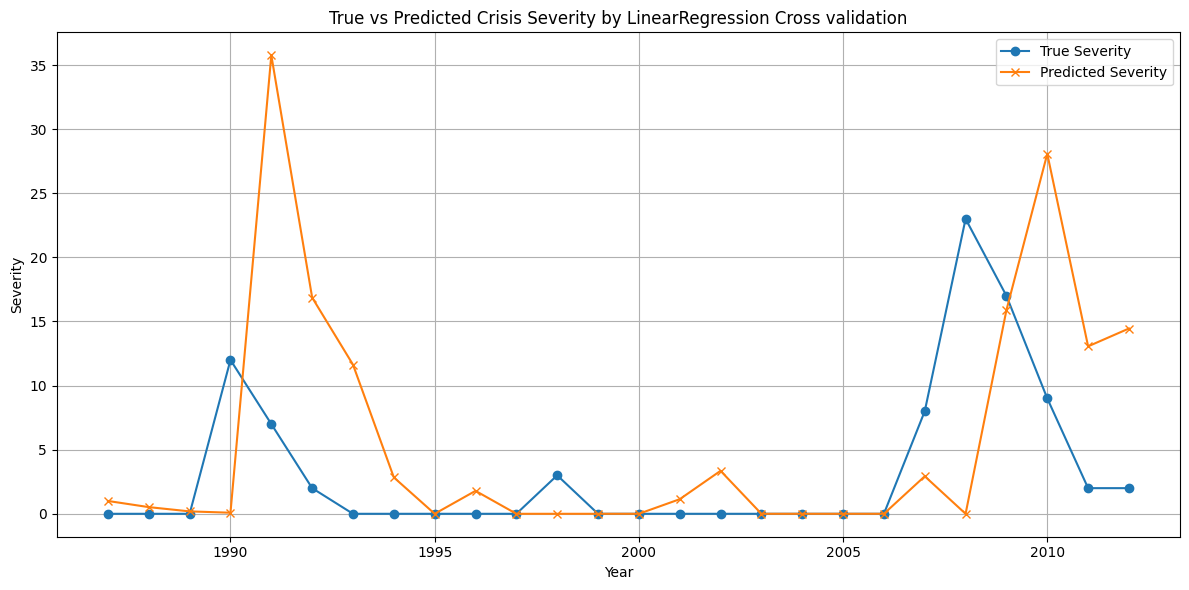

In [139]:
# 1.3.2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# 线性回归-交叉验证
k = 26
tscv = TimeSeriesSplit(n_splits=k)

# 存储每次预测的真实值和预测值
true_values = []
predictions = []

for train_index, test_index in tscv.split(X):
    # print('train_index:',train_index,'  test_index:',test_index)
    # 滚动训练集和测试集
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 创建模型
    model = LinearRegression()
    
    # 训练模型
    model.fit(X_train, y_train)
    
    # 预测
    y_pred = model.predict(X_test)
    
    # 将预测值和真实值存储起来
    predictions.extend(y_pred)
    true_values.extend(y_test)

# 计算性能指标
mse = mean_squared_error(true_values, predictions)/k
print("Average Mean Squared Error:", mse)

for i in range(len(predictions)):
    if predictions[i] < 0:
        predictions[i] = 0
plt.figure(figsize=(12, 6))
years = range(1987, 2013)  # 确保年份范围正确
# 绘制真实严重性
plt.plot(years, true_values, label='True Severity', marker='o', linestyle='-')
# 绘制预测严重性
plt.plot(years, predictions, label='Predicted Severity', marker='x', linestyle='-')

plt.xlabel('Year')
plt.ylabel('Severity')
plt.title('True vs Predicted Crisis Severity by LinearRegression Cross validation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [140]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# 线性回归,留出验证（Holdout Validation）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建线性回归模型
linear_model = LinearRegression()

# 训练模型
linear_model.fit(X_train, y_train)

# 预测测试集
y_pred = linear_model.predict(X_test)

# 计算模型的性能指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 184.0343152018684
R^2 Score: -20.440891091479813


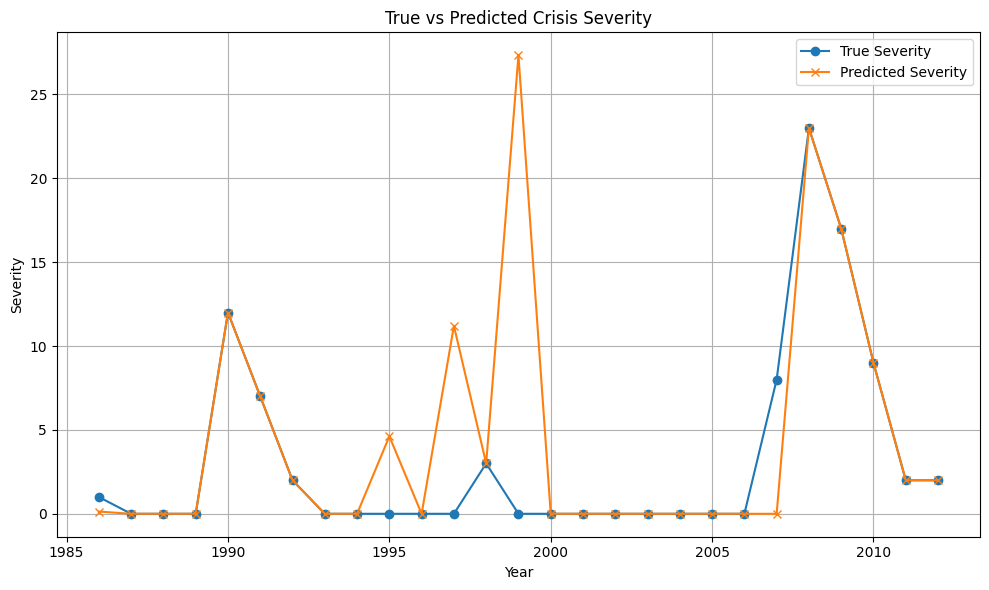

CPU times: total: 312 ms
Wall time: 401 ms


In [143]:
%%time
import matplotlib.pyplot as plt
# linear_labels 和 predictions 分别是真实标签和预测结果，确保 linear_labels 和 predictions 的长度相同
predictions = linear_model.predict(X)
for i in range(len(predictions)):
    if predictions[i] < 0:
        predictions[i] = 0
linear_labels = y

# 使用 Matplotlib 绘制折线图
years = range(1986, 2013)  # 确保年份范围正确
plt.figure(figsize=(10, 6))

# 绘制真实严重性
plt.plot(years, linear_labels, label='True Severity', marker='o', linestyle='-')

# 绘制预测严重性
plt.plot(years, predictions, label='Predicted Severity', marker='x', linestyle='-')

plt.xlabel('Year')
plt.ylabel('Severity')
plt.title('True vs Predicted Crisis Severity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
import pandas as pd

# 读取Excel文件
gdp_data = pd.read_excel('./美国GDP.xlsx')

# 显示前几行数据
print(gdp_data.head())

  Country Name Country Code Indicator Name  Indicator Code          1960  \
0           美国          USA      GDP（现价美元）  NY.GDP.MKTP.CD  543300000000   

           1961          1962          1963          1964          1965  ...  \
0  563300000000  605100000000  638600000000  685800000000  743700000000  ...   

             2013            2014            2015            2016  \
0  16843190993000  17550680174000  18206020741000  18695110842000   

             2017            2018            2019            2020  \
0  19477336549000  20533057312000  21380976119000  21060473613000   

             2021            2022  
0  23315080560000  25462700000000  

[1 rows x 67 columns]


In [70]:
# 转换数据，使每一行代表一个年份，每一列代表GDP
gdp_data = gdp_data.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], 
                          var_name='Year', 
                          value_name='GDP')

# 转换年份列为整数类型
gdp_data['Year'] = gdp_data['Year'].astype(int)

# 确保GDP列是浮点数类型
gdp_data['GDP'] = gdp_data['GDP'].astype(float)

# 现在DataFrame是按年份排列的，可以进行进一步的分析
print(gdp_data.head())

  Country Name Country Code Indicator Name  Indicator Code  Year           GDP
0           美国          USA      GDP（现价美元）  NY.GDP.MKTP.CD  1960  5.433000e+11
1           美国          USA      GDP（现价美元）  NY.GDP.MKTP.CD  1961  5.633000e+11
2           美国          USA      GDP（现价美元）  NY.GDP.MKTP.CD  1962  6.051000e+11
3           美国          USA      GDP（现价美元）  NY.GDP.MKTP.CD  1963  6.386000e+11
4           美国          USA      GDP（现价美元）  NY.GDP.MKTP.CD  1964  6.858000e+11


In [71]:
# 假设 labels_df 是您之前创建的包含原始标签和预测年份的DataFrame
# 假设 gdp_data 是您的GDP数据DataFrame，包含年份和GDP值

# 计算GDP增长率，定义增长率为 (当前年份GDP - 前一年份GDP) / 前一年份GDP
gdp_data['GDP_Growth'] = gdp_data['GDP'].pct_change()
# 首先，确保两个DataFrame中年份列的数据类型一致
labels['Prediction_Year'] = labels['Prediction_Year'].astype(int)
gdp_data['Year'] = gdp_data['Year'].astype(int)

# 使用merge函数将GDP数据合并到标签DataFrame中
# 我们在这里假设您想要保留所有的标签行，即使某些年份在GDP数据中没有对应的条目
# 因此，我们使用了左连接（left join）
labels_with_gdp = labels.merge(gdp_data[['Year', 'GDP','GDP_Growth']], left_on='Prediction_Year', right_on='Year', how='left')

# 如果您不想保留GDP数据中没有的年份，可以使用内连接（inner join）
# labels_with_gdp = labels_df.merge(gdp_data[['Year', 'GDP']], left_on='Prediction_Year', right_on='Year', how='inner')

# 检查合并结果
print(labels_with_gdp.head())

   Severity  Binary_Crisis  Prediction_Year  Year           GDP  GDP_Growth
0       1.0            1.0             1986  1986  4.579631e+12    0.055463
1       0.0            0.0             1987  1987  4.855215e+12    0.060176
2       0.0            0.0             1988  1988  5.236438e+12    0.078518
3       0.0            0.0             1989  1989  5.641580e+12    0.077370
4      12.0            1.0             1990  1990  5.963144e+12    0.056999


In [72]:
# 分离特征和标签
X = features
y_gdp = labels_with_gdp['GDP']  # GDP的实际值
y_gdp_growth = labels_with_gdp['GDP_Growth']  # GDP的增长率
print(len(X))
print(len(y_gdp))
print(len(y_gdp_growth))
y_gdp_growth.describe()

26
26
26


count    26.000000
mean      0.050638
std       0.020193
min      -0.019756
25%       0.041492
50%       0.056650
75%       0.062498
max       0.078518
Name: GDP_Growth, dtype: float64

In [73]:
# 划分训练集和测试集
X_train_gdp, X_test_gdp, y_train_gdp, y_test_gdp = train_test_split(X, y_gdp, test_size=0.2, random_state=42)

X_train_growth, X_test_growth, y_train_growth, y_test_growth = train_test_split(X, y_gdp_growth*100, test_size=0.2, random_state=42)

# 创建线性回归模型
linear_model_gdp = LinearRegression()
linear_model_growth = LinearRegression()

# 训练GDP实际值的模型
linear_model_gdp.fit(X_train_gdp, y_train_gdp)
# 训练GDP增长率的模型
linear_model_growth.fit(X_train_growth, y_train_growth)

# 预测测试集
y_pred_gdp = linear_model_gdp.predict(X_test_gdp)
y_pred_growth = linear_model_growth.predict(X_test_growth)

# 计算模型的性能指标
mse_gdp = mean_squared_error(y_test_gdp, y_pred_gdp)
r2_gdp = r2_score(y_test_gdp, y_pred_gdp)

mse_growth = mean_squared_error(y_test_growth, y_pred_growth)
r2_growth = r2_score(y_test_growth, y_pred_growth)

# 输出模型性能
print("GDP Model MSE:", mse_gdp)
print("GDP Model R^2:", r2_gdp)

print("Growth Model MSE:", mse_growth)
print("Growth Model R^2:", r2_growth)

GDP Model MSE: 4.281973167356304e+23
GDP Model R^2: 0.9603599105464566
Growth Model MSE: 12.343217680140677
Growth Model R^2: -8.852973878756531


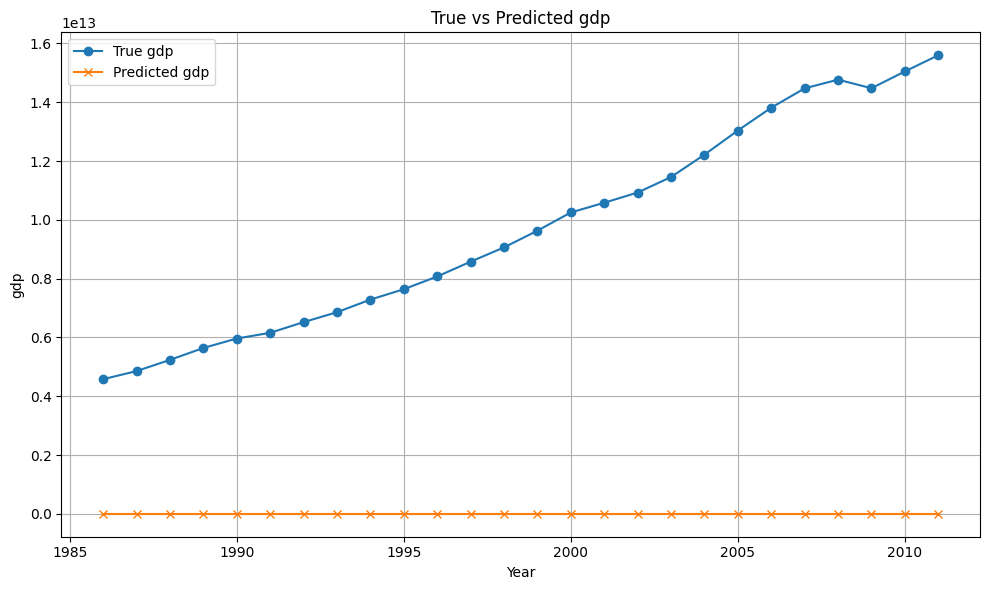

In [74]:
# linear_labels 和 predictions 分别是真实标签和预测结果，确保 linear_labels 和 predictions 的长度相同
predictions_gdp = linear_model_gdp.predict(X)
linear_labels = y_gdp

# 使用 Matplotlib 绘制折线图
years = range(1986, 2012)  # 确保年份范围正确
plt.figure(figsize=(10, 6))

# 绘制真实严重性
plt.plot(years, linear_labels, label='True gdp', marker='o', linestyle='-')

# 绘制预测严重性
plt.plot(years, predictions, label='Predicted gdp', marker='x', linestyle='-')

plt.xlabel('Year')
plt.ylabel('gdp')
plt.title('True vs Predicted gdp')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

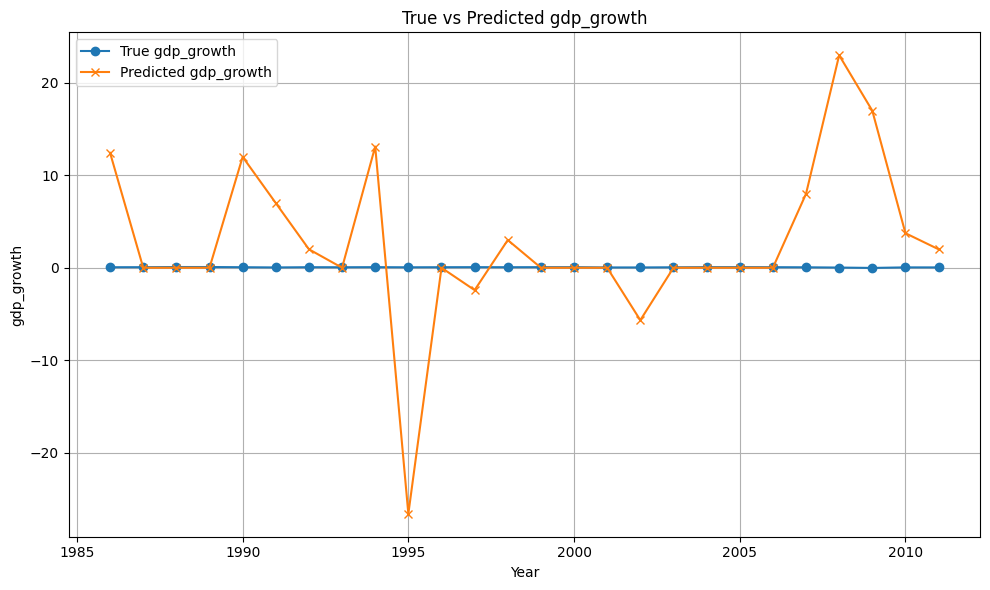

In [75]:
# linear_labels 和 predictions 分别是真实标签和预测结果，确保 linear_labels 和 predictions 的长度相同
predictions_gdp = linear_model_gdp.predict(X)
linear_labels = y_gdp_growth

# 使用 Matplotlib 绘制折线图
years = range(1986, 2012)  # 确保年份范围正确
plt.figure(figsize=(10, 6))

# 绘制真实严重性
plt.plot(years, linear_labels, label='True gdp_growth', marker='o', linestyle='-')

# 绘制预测严重性
plt.plot(years, predictions, label='Predicted gdp_growth', marker='x', linestyle='-')

plt.xlabel('Year')
plt.ylabel('gdp_growth')
plt.title('True vs Predicted gdp_growth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
# 对GDP数据进行归一化再预测
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# 初始化MinMaxScaler，使其范围在[0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))

# 使用归一化的GDP值作为标签
y_gdp_normalized = scaler.fit_transform(y_gdp.values.reshape(-1, 1)).flatten()

# 划分归一化后的训练集和测试集
X_train_gdp_norm, X_test_gdp_norm, y_train_gdp_norm, y_test_gdp_norm = train_test_split(
    X, y_gdp_normalized, test_size=0.2, random_state=42
)

# 创建线性回归模型
linear_model_gdp_norm = LinearRegression()

# 训练归一化GDP值的模型
linear_model_gdp_norm.fit(X_train_gdp_norm, y_train_gdp_norm)

# 预测测试集
y_pred_gdp_norm = linear_model_gdp_norm.predict(X_test_gdp_norm)

# 反归一化预测值以便比较
y_pred_gdp = scaler.inverse_transform(y_pred_gdp_norm.reshape(-1, 1)).flatten()

# 计算反归一化后的预测值的性能指标
mse_gdp = mean_squared_error(y_test_gdp, y_pred_gdp)
r2_gdp = r2_score(y_test_gdp, y_pred_gdp)

print("Normalized GDP Model MSE:", mse_gdp)
print("Normalized GDP Model R^2:", r2_gdp)

Normalized GDP Model MSE: 4.2819731673564105e+23
Normalized GDP Model R^2: 0.9603599105464556


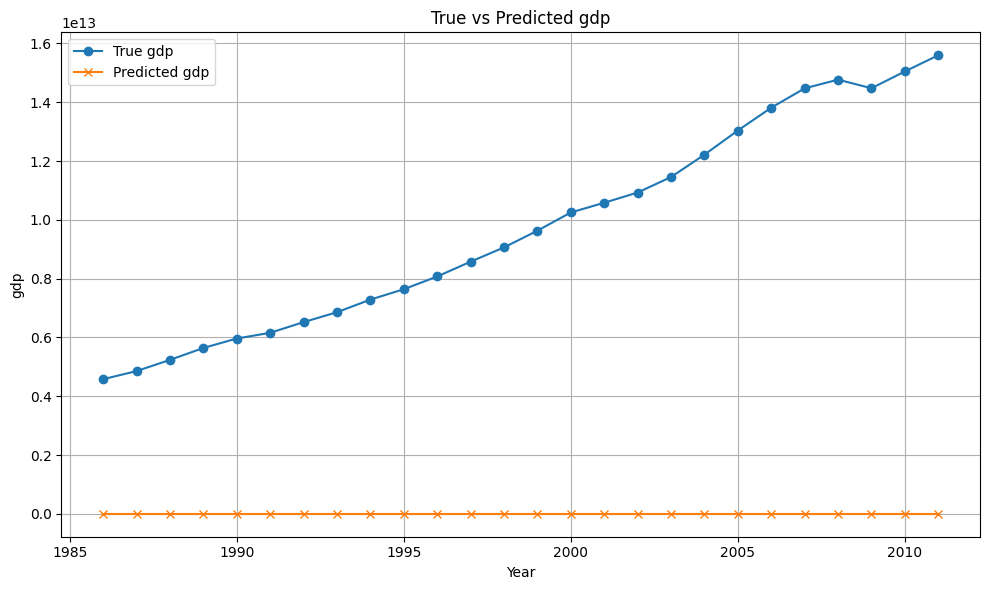

In [77]:
# linear_labels 和 predictions 分别是真实标签和预测结果，确保 linear_labels 和 predictions 的长度相同
predictions_gdp = linear_model_gdp_norm.predict(X)
linear_labels = y_gdp

# 使用 Matplotlib 绘制折线图
years = range(1986, 2012)  # 确保年份范围正确
plt.figure(figsize=(10, 6))

# 绘制真实严重性
plt.plot(years, linear_labels, label='True gdp', marker='o', linestyle='-')

# 绘制预测严重性
plt.plot(years, predictions, label='Predicted gdp', marker='x', linestyle='-')

plt.xlabel('Year')
plt.ylabel('gdp')
plt.title('True vs Predicted gdp')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()